In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.metrics import r2_score, mean_absolute_error, make_scorer, mean_squared_error, mean_absolute_percentage_error

from sklearn.linear_model import LinearRegression, Lasso, RANSACRegressor, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR, LinearSVR


In [3]:
plt.style.use('seaborn')

In [4]:
np.random.seed(1234)

In [5]:
def make_grid_train_model(estimator, params, cv, train_feat, train_tar):
    """
    This method creates a grid search and prints 
    r2_score, 
    mean_absolute_error, 
    mean_absolute_percentage_error, 
    grid.best_params 
    """
    grid = GridSearchCV(estimator=estimator, param_grid=params, cv=cv, return_train_score=True)
    grid.fit(train_feat, train_tar)
    
    print('GRID results:')
    pred = grid.predict(train_feat)
    print(f'R2 Score: {r2_score(np.expm1(train_tar), np.expm1(pred))}')
    print(f'Mean Absolute Error: {mean_absolute_error(np.expm1(train_tar), np.expm1(pred))}')
    print(f'Mean Absolute Percentage Error: {mean_absolute_percentage_error(np.expm1(train_tar), np.expm1(pred))}')
    print(f'Best grid params: {grid.best_params_}')
    
    return grid
# 
def plot_cv_results_curves(cv_results, best_index):
    """
    This method plots cv_results curves
    """
    plt.figure(figsize=(15, 5))
    
    plt.plot(cv_results.index, cv_results['mean_train_score'], marker='o', markersize = 5, label = 'train score')
    plt.plot(cv_results.index, cv_results['mean_test_score'], marker='s', markersize = 5, label = 'validation score')
 
    plt.axvline(best_index, label = 'best score', color='orange', linestyle='dotted')
    
    plt.xlim(0, len(cv_results))
    plt.title('Scores of the parameter combination')
    plt.xlabel('Index of params combination')
    plt.ylabel('Score of params combination')
    
    plt.legend()
    plt.show()
    
def final_evaluation(model, X_train, y_train, X_test, y_test):
    """
    This method returns r2_train, mae, mape
    """
    pred_train = model.predict(X_train)
    r2_train = r2_score(np.expm1(y_train), np.expm1(pred_train))
    mae = mean_absolute_error(np.expm1(y_train), np.expm1(pred_train))
    mape = mean_absolute_percentage_error(np.expm1(y_train), np.expm1(pred_train))
    
    return r2_train, mae, mape

def mutual_plot(model, features, target):
    
    """
    This method plots mutual diagrames of model`s results with train data - histograms with distribution of target an predicted prices 
    and scatter plots of residuals
    """

    plt.figure(figsize=(15, 3)).suptitle('Distribution of predictions and residuals after inverse log transformation of data')
    predictions = model.predict(features)
        
    plt.subplot(1,4,1)
    plt.hist(np.expm1(target), label='target', alpha=0.7, bins=50)
    plt.hist(np.expm1(predictions), label='predicted', alpha=0.7, bins=50)
    plt.xlabel('Price values')
    plt.ylabel('Distribution')
    plt.legend()

    plt.subplot(1,4,2)
    plt.scatter(np.expm1(target), np.expm1(predictions), s=5)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')

    plt.subplot(1,4,3)
    plt.hist(np.expm1(target) - np.expm1(predictions), bins=50)
    plt.axvline([0], color='orange')
    plt.xlabel('Residuals')
    plt.ylabel('Distribution')

    plt.subplot(1,4,4)
    plt.scatter(np.expm1(predictions), np.expm1(target) - np.expm1(predictions) , s=5)
    plt.xlabel('Predicted')
    plt.ylabel('Residuals')
    plt.axhline([0], c='orange')
    
    plt.gca().set_aspect('equal')
    plt.tight_layout()
    plt.show()



 ## <div style="text-align: center">ПРОЕКТ ЗА СЪЗДАВАНЕ НА МОДЕЛИ ЗА ПРЕДВИЖДАНЕ НА ЦЕНИ НА НЕДВИЖИМИ ИМОТИ - ЕДНОФАМИЛНИ ЖИЛИЩА</div>

Оценката на цените на жилищата е важно финансово решение за всички участници на пазара на жилища - предприемачи, брокери, оценители, финансови институции и потенциални купувачи. Независимо от ролята на всеки един в процесите, които протичат, всеки един субект се интересува от потенциалната печалба, от пазарната стойност на обекта, който придобива или печалбата, която може да реализира.<br>
По дефиниция,  в ЕВРОПЕЙСКИТЕ СТАНДАРТИ ЗА ОЦЕНЯВАНЕ (EСО) - 2020 г., определението за „Пазарна стойност” е: „Оценената сума, срещу която даден актив или пасив може да смени собственика си към датата на оценката чрез сделка между независими един от друг, желаещ купувач и желаещ продавач, след подходящ маркетинг, при което всяка от страните е действала информирано, благоразумно и без принуда”.<br>
В този проект ще разгледаме възможни алгоритми за машинно обучение, с цел да бъде разработена система за прогнозиране на цени на жилища. Същите не могат да бътат третирани като Пазарна Стойност изведена съгласно стандартите за оценяване на недвижими имоти.<br>


Изследването се състои от четири етапа, а именно:
* четене на предварително събрани данни, запълване на липсващи стойности, обработка на независимите променливи, анализ и трансформация във формат, подходящ да бъдат приложени в тренирането на модели за машинно обучение.
* трениране и  валидиране на модели за машинно обучение
* сравнение, анализ и избор на най-успешния модел
* тестване на избрания модел

Опитът в оценяването на недвижими имоти, показва, че стойността, на която се извършват сделките, често е повлияна от субективни фактори, както и явления на пазара, които могат да останат скрити. В резултат на това,  се приема за нормално становището на независим оценител за пазарната стойност на обект, да се различава от стойността на реализацията му. Негласно, в пактиката на оценяването, се допуска, че в изведената пазарна стойност за един и същи имот, на двама независимо работещи един от друг оценители или от стойността на сделката, може да има отклонение в размер на от 5% до 7%. Това е валидно за оценката на един самостоятелен актив.<br>
За изготвените модели ще разгледаме процентната грешка и ще видим дали биха могли да постигнат оценка на индивидуални активи в рамките на същите 5% за всеки един оценен актив.<br> 
Стартираме проекта, при допускането, че данните с които ще работим са "замърсени" от явления и решения, които не могат да бъдат обективно измерени и описани, както и че целта е предвиждане на евентуална цена на реализация, а не извеждане на пазарна стойност на обектите. <br>


За целите на настоящия проект се използват данни от https://www.kaggle.com/c/house-prices-advanced-regression-techniques

### Прочитане и запознаване с данните

In [6]:
row_data = pd.read_csv('houses_data.csv')
row_data.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [7]:
row_data.shape

(1460, 81)

In [8]:
row_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

### Почистване на данните и попълване на липсващи стойности

In [9]:
missing_values = row_data.isnull().sum()
missing_values[missing_values>0]

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

* Нечислови променливи - Alley, MasVnrType, BsmtQual, BsmtCond, BsmtExposure,   BsmtFinType1, BsmtFinType2, Electrical, FireplaceQu,  GarageType,   GarageFinish, GarageQual, GarageCond, PoolQC, Fence, MiscFeature - След обследване на променливите се вижда, че липсващите стойности в нечисловите променливи са всъщност клас, който показва отсъствието на комфорт факторът и затова същата се заменя с  "Not available".<br>
* Числови променливи  LotFrontage, MasVnrArea, GarageYrBlt се запълват с медианата стойност за категорията, тъй като записите не са много и това е по адекватно решение от средната стойност. 

In [10]:
# Запълвам всички нечислови липсващи стойности с "not available"
for col in row_data.select_dtypes(include = ['object']): 
    row_data[col].fillna('Not available', inplace= True)

In [11]:
# Запълвам всички числови липсващи стойности с средната за променливата стойност.
for col in row_data.select_dtypes(exclude= ['object']): 
    row_data[col].fillna(row_data[col].median(), inplace= True)

In [12]:
# Правим проверка дали стойностите са запълнени.
row_data.isna().sum().sum()

0

In [13]:
# За удобство правим трансформация на цената и премахваме колоната Id
row_data = row_data.drop('Id', axis=1)
row_data.SalePrice = row_data.SalePrice.divide(other=1000)

In [14]:
# Присвояваме към променливи числовите и нечисловите колони
categorical_columns = row_data.select_dtypes(include=['object'])
numerical_columns = row_data.select_dtypes(exclude=['object'])
len(categorical_columns.columns), len(numerical_columns.columns), len(row_data.columns)

(43, 37, 80)

### Анализ на зависимата променлива 

In [15]:
row_data.SalePrice.describe()

count    1460.000000
mean      180.921196
std        79.442503
min        34.900000
25%       129.975000
50%       163.000000
75%       214.000000
max       755.000000
Name: SalePrice, dtype: float64

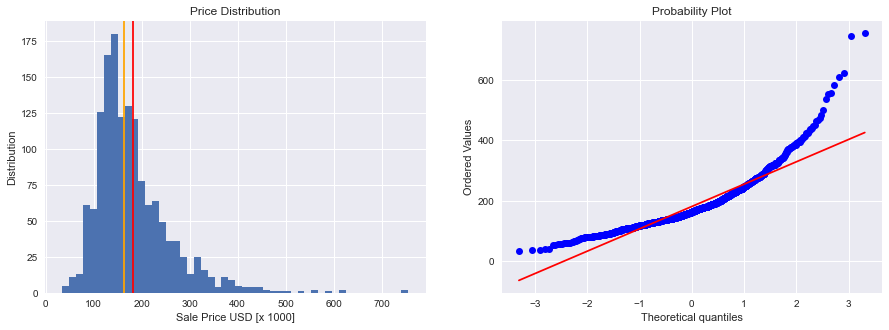

In [16]:
plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.hist(row_data.SalePrice, bins=50)
plt.axvline(row_data.SalePrice.mean(), color='red')
plt.axvline(row_data.SalePrice.median(), color='orange')
plt.title('Price Distribution')
plt.xlabel('Sale Price USD [х 1000]')
plt.ylabel('Distribution')

plt.subplot(1,2,2)
stats.probplot(row_data['SalePrice'], plot=plt)

plt.show()

От описанието и хистограмата на променливата "Цена", се вижда, че 75% от стойностите на имотите са под 214 хил, което ще създаде проблем при предвижданията, заради неправилното разпределение.<br>
Ще приложим логаритмична трансформация, за да видим дали, чрез нея ще постигнем добро разпределение чрез което грешките при прогнозиране на скъпи къщи и евтини къщи да повлияят еднакво на резултата.

In [17]:
log_prices = np.log1p(row_data.SalePrice)

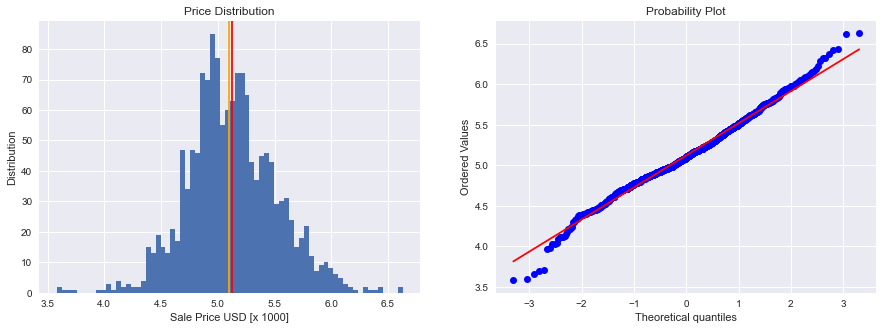

In [18]:
plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.hist(log_prices, bins=70)
plt.axvline(log_prices.mean(), color='red')
plt.axvline(log_prices.median(), color='orange')
plt.title('Price Distribution')
plt.xlabel('Sale Price USD [х 1000]')
plt.ylabel('Distribution')

plt.subplot(1,2,2)
stats.probplot(log_prices, plot=plt)

plt.show()

### Анализ на числовите променливи

Пристъпваме към анализа с изготвяне на scatter plots и хистограми, за да видим отношението на числовите променливи със зависимата такава, както и тяхното разпределение в данните.

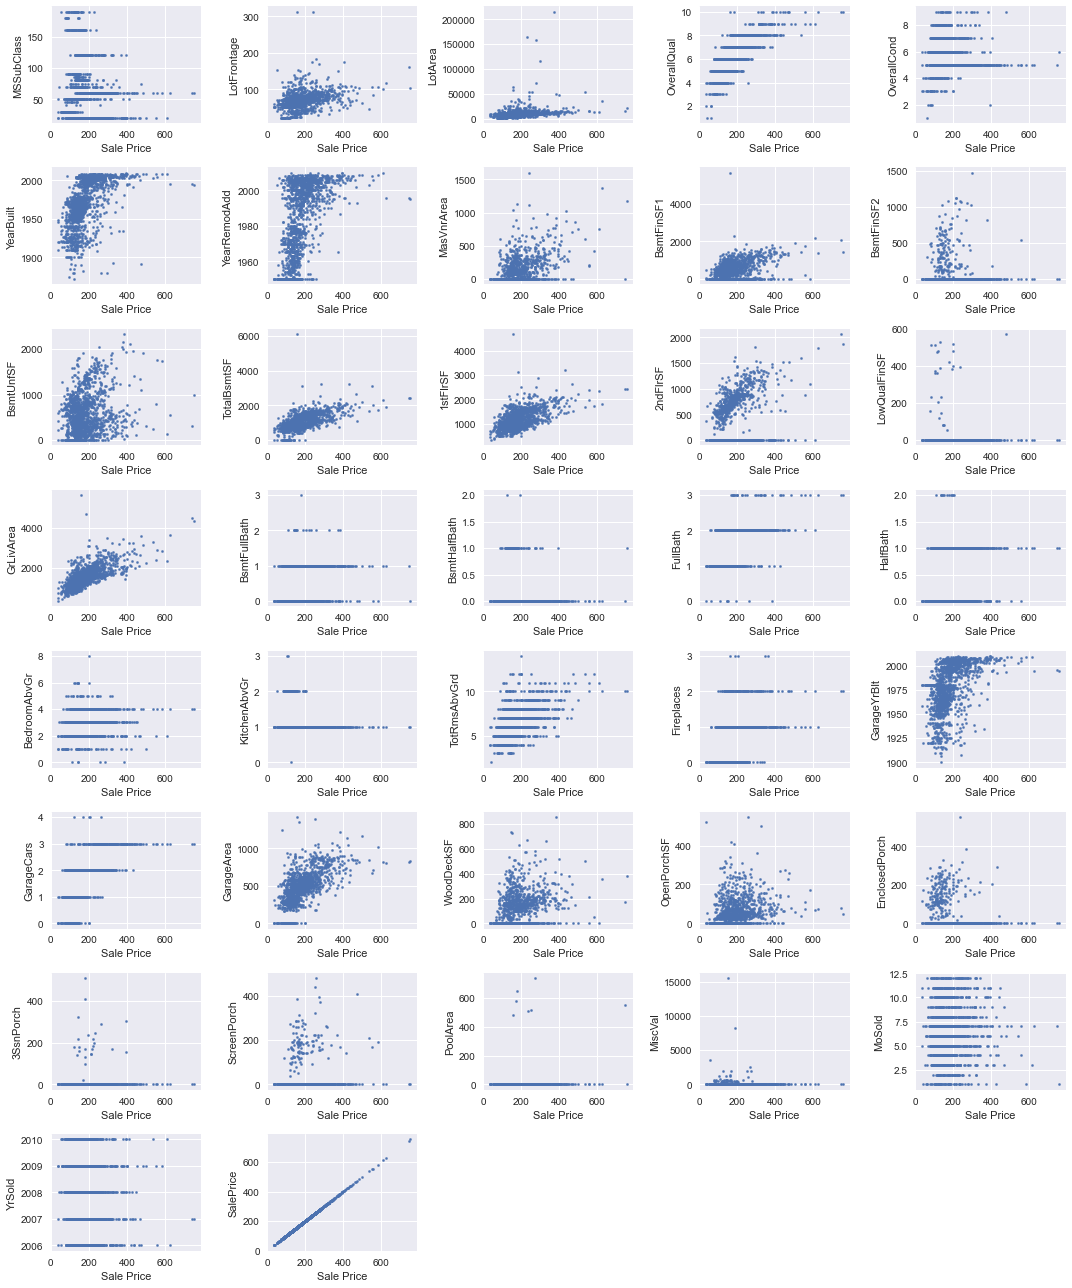

In [19]:
plt.figure(figsize=(15, 18))

i = 1
for col in numerical_columns:
    plt.subplot(8,5,i)
    plt.scatter(row_data.SalePrice, row_data[col], s=5)
    plt.xlabel('Sale Price')
    plt.ylabel(col)
    i +=1
    
plt.tight_layout()
plt.show()

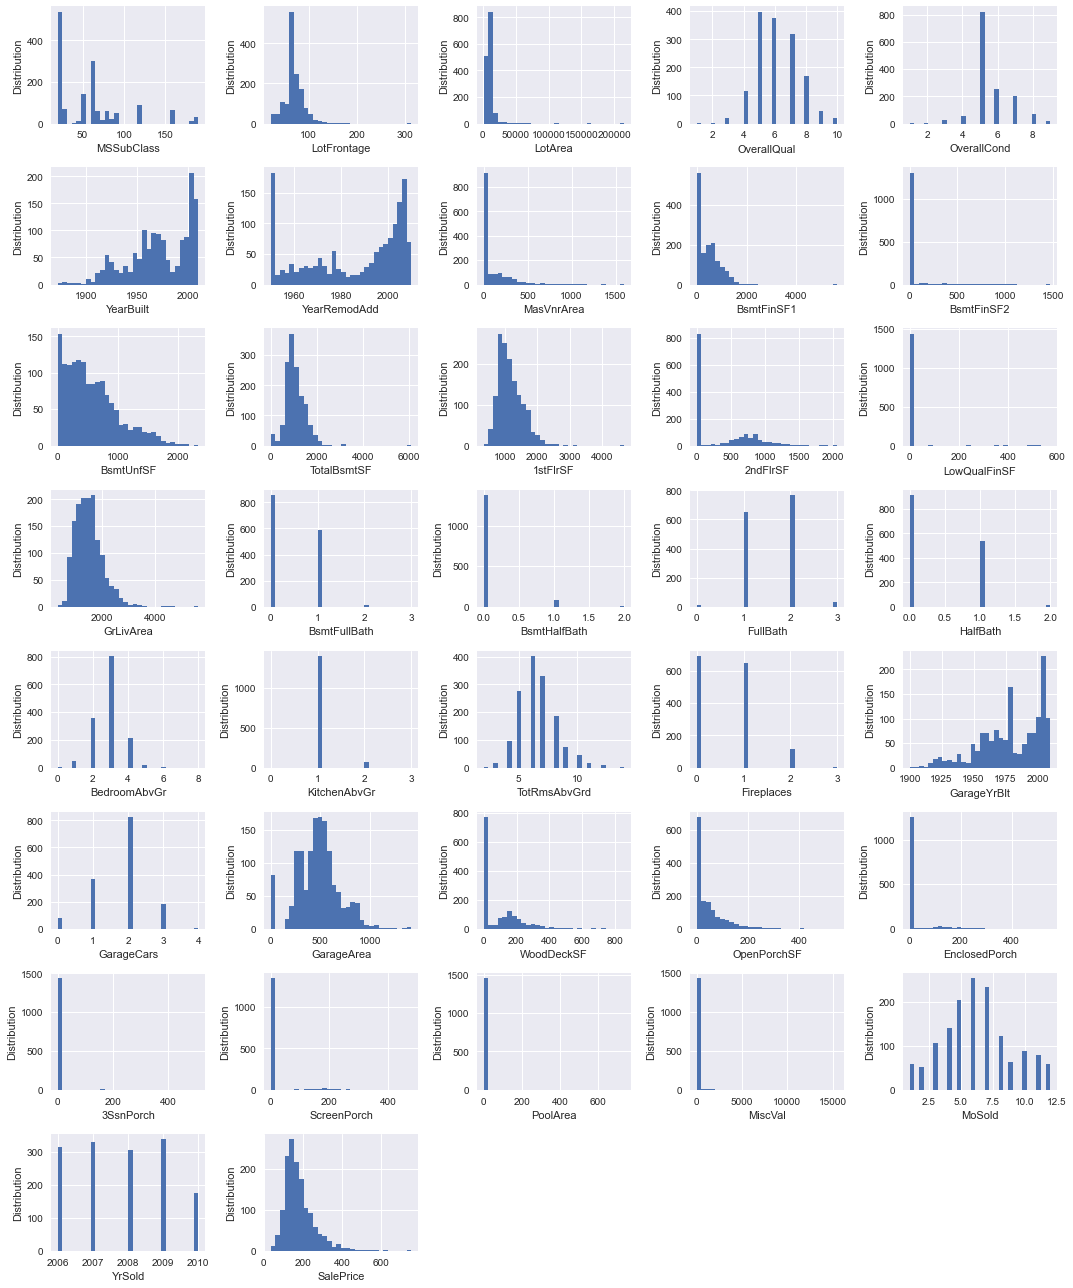

In [20]:
plt.figure(figsize=(15, 18))

i = 1
for col in numerical_columns:
    plt.subplot(8,5,i)
    plt.hist(row_data[col], bins=30)
    plt.xlabel(col)
    plt.ylabel('Distribution')
    i +=1
    
plt.tight_layout()
plt.show()

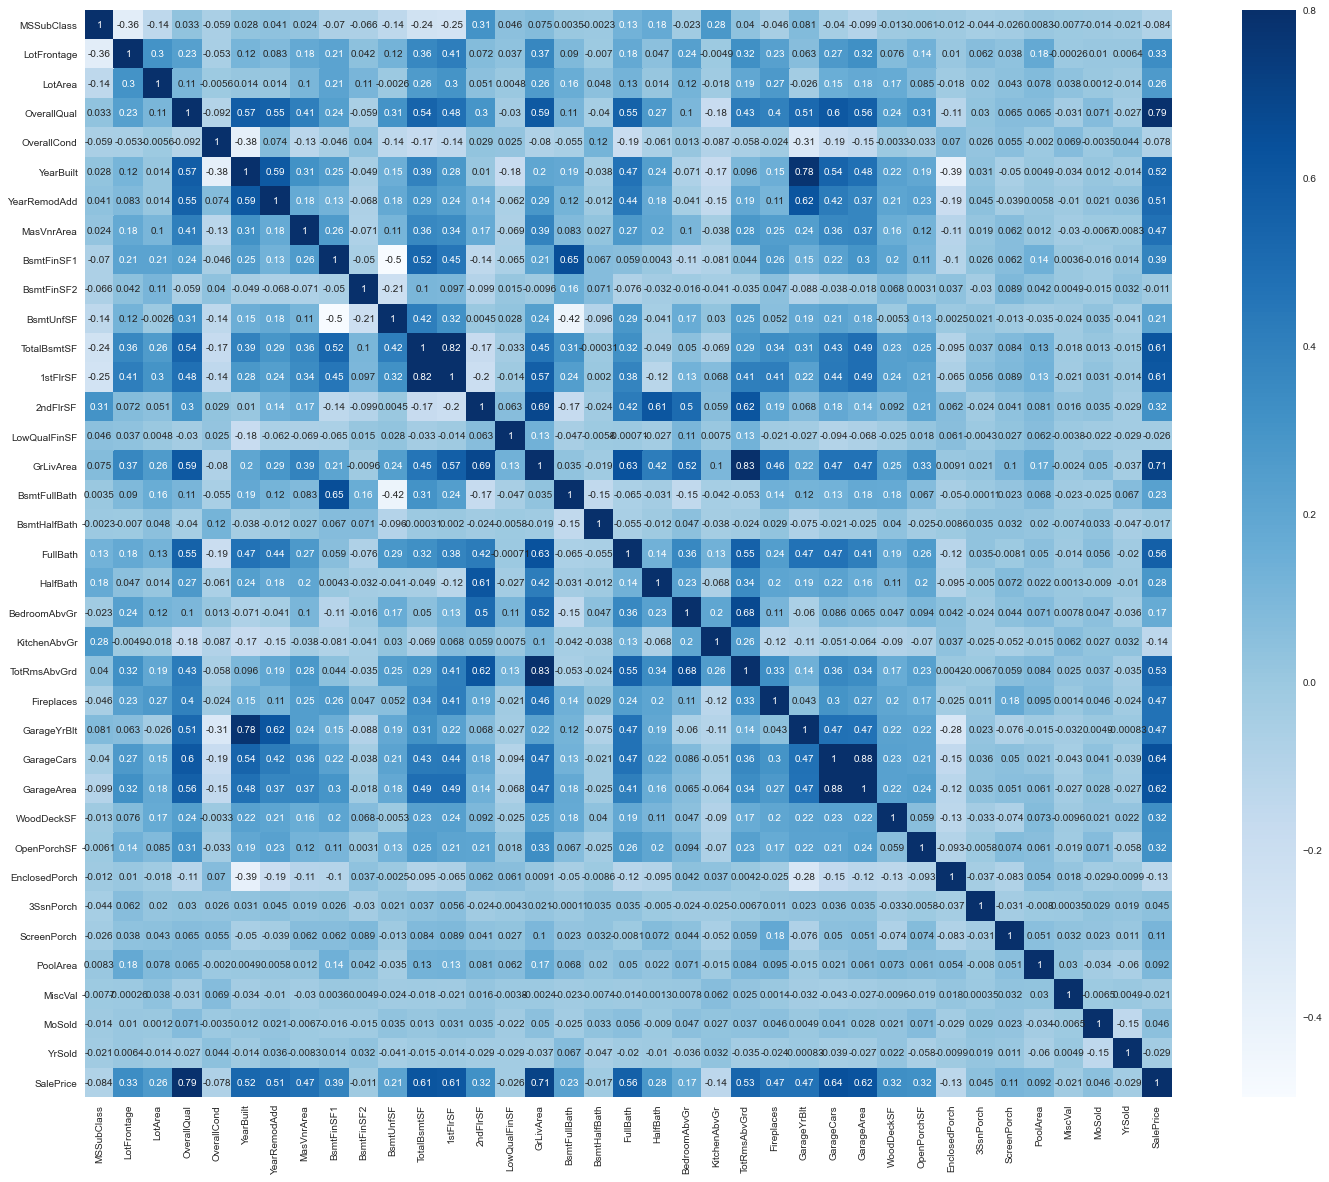

In [21]:
corr_mat = row_data.corr()
k = len(row_data.columns)
cols = corr_mat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(row_data[cols].values)
f, ax = plt.subplots(figsize=(25, 20))

sns.heatmap(corr_mat, vmax=.8, square=True, annot = True, cmap = 'Blues')
plt.show()

От диаграмите се вижда, че по-голямата част от независимите числови променливи са с изкривяване в разпределението /позитивно или негативно/. Матрицата на корелация показва, че освен със зависимата променлива, същите корелират помежду си, което е предпоставка за объркване на моделите.<br>
При голяма част от променливите данните са с хетероскедастична форма. В този проект ще тренираме моделите, за да преценим в каква степен същата остава в резултатите. След анализ на резултатите ще преценим доколко и какви действия могат да бъдат предприети за решаването на този проблем.

#### Подбор на числовите променливи /feature selection/
* Премахваме променливите, които са с корелация със зависимата променлива м/у -0,05 и 0,05 и които на практика почи не оказват влияние върху стойността.
* Площта на гаража /GarageArea/ и броят коли, за които е предназначен са препокриващи се променливи, силно зависими една от друга. Премахваме площта, която е смалко по-ниска корелация.
* Премахваме променливата за площ на първи и втори етаж. Има променливи с цялата площ на сградата. Като информацията за етажността на сградата остава в друга нечислова променлива - тип на сградата.
* Премахваме променливата за завършен сутерен от различен тип и променливата за незавършена площ, която е обща за двата типа, което също води до объркване. Работим само с площ на целия сутерен.
* Променливата касаеща броят стаи в сградата /TotRmsAbvGrd/, силно корелира с други променливи, които на практика я описват - брой спални, кухни и т.н.
* Цифровата променлива MSSubClass, по смисълът си трябва да е категорийна, преобразувам в такива. 
* Още две променливи /OverallQual, OverallCond/ биха могли да бъдат превърнати в категорийни, но предвид предстоящият им енкодинг, както и правлната градация в подредбата им, оставяме цифрови.
* Променливите за площ на басейн и видове веранди на сградата, са с много малко представяне в данните. В по-голямата част от записите стойностите им са нулеви, което на практика означава, че такива няма. Превръщаме тези променливи в категорийни със стойности Yes за наличност на комфорт факторът и No за отсъствие на такъв.

In [22]:
low_price_corr_columns = corr_mat['SalePrice'][abs(corr_mat['SalePrice'].values) < 0.05].index.values
low_price_corr_columns

array(['BsmtFinSF2', 'LowQualFinSF', 'BsmtHalfBath', '3SsnPorch',
       'MiscVal', 'MoSold', 'YrSold'], dtype=object)

In [23]:
row_data = row_data.drop(list(low_price_corr_columns), axis=1)

In [24]:
columns_to_drop = ['GarageArea', 
                   'GarageYrBlt', 
                   '1stFlrSF', 
                   '2ndFlrSF', 
                   'BsmtFinSF1', 
                   'BsmtUnfSF', 
                   'TotRmsAbvGrd']
row_data = row_data.drop(columns_to_drop, axis=1)

In [25]:
row_data.PoolArea = row_data.PoolArea.apply(lambda x: 'No' if x == 0 else 'Yes')
row_data.WoodDeckSF = row_data.WoodDeckSF.apply(lambda x: 'No' if x == 0 else 'Yes')
row_data.OpenPorchSF = row_data.OpenPorchSF.apply(lambda x: 'No' if x == 0 else 'Yes')
row_data.EnclosedPorch = row_data.EnclosedPorch.apply(lambda x: 'No' if x == 0 else 'Yes')
row_data.ScreenPorch = row_data.ScreenPorch.apply(lambda x: 'No' if x == 0 else 'Yes')

In [26]:
row_data.MSSubClass = row_data.MSSubClass.astype('object')

### Анализ на категорийните променливи

In [27]:
# презаписвам променливата след направената по-горе корекция
categorical_columns = row_data.select_dtypes(include=['object'])

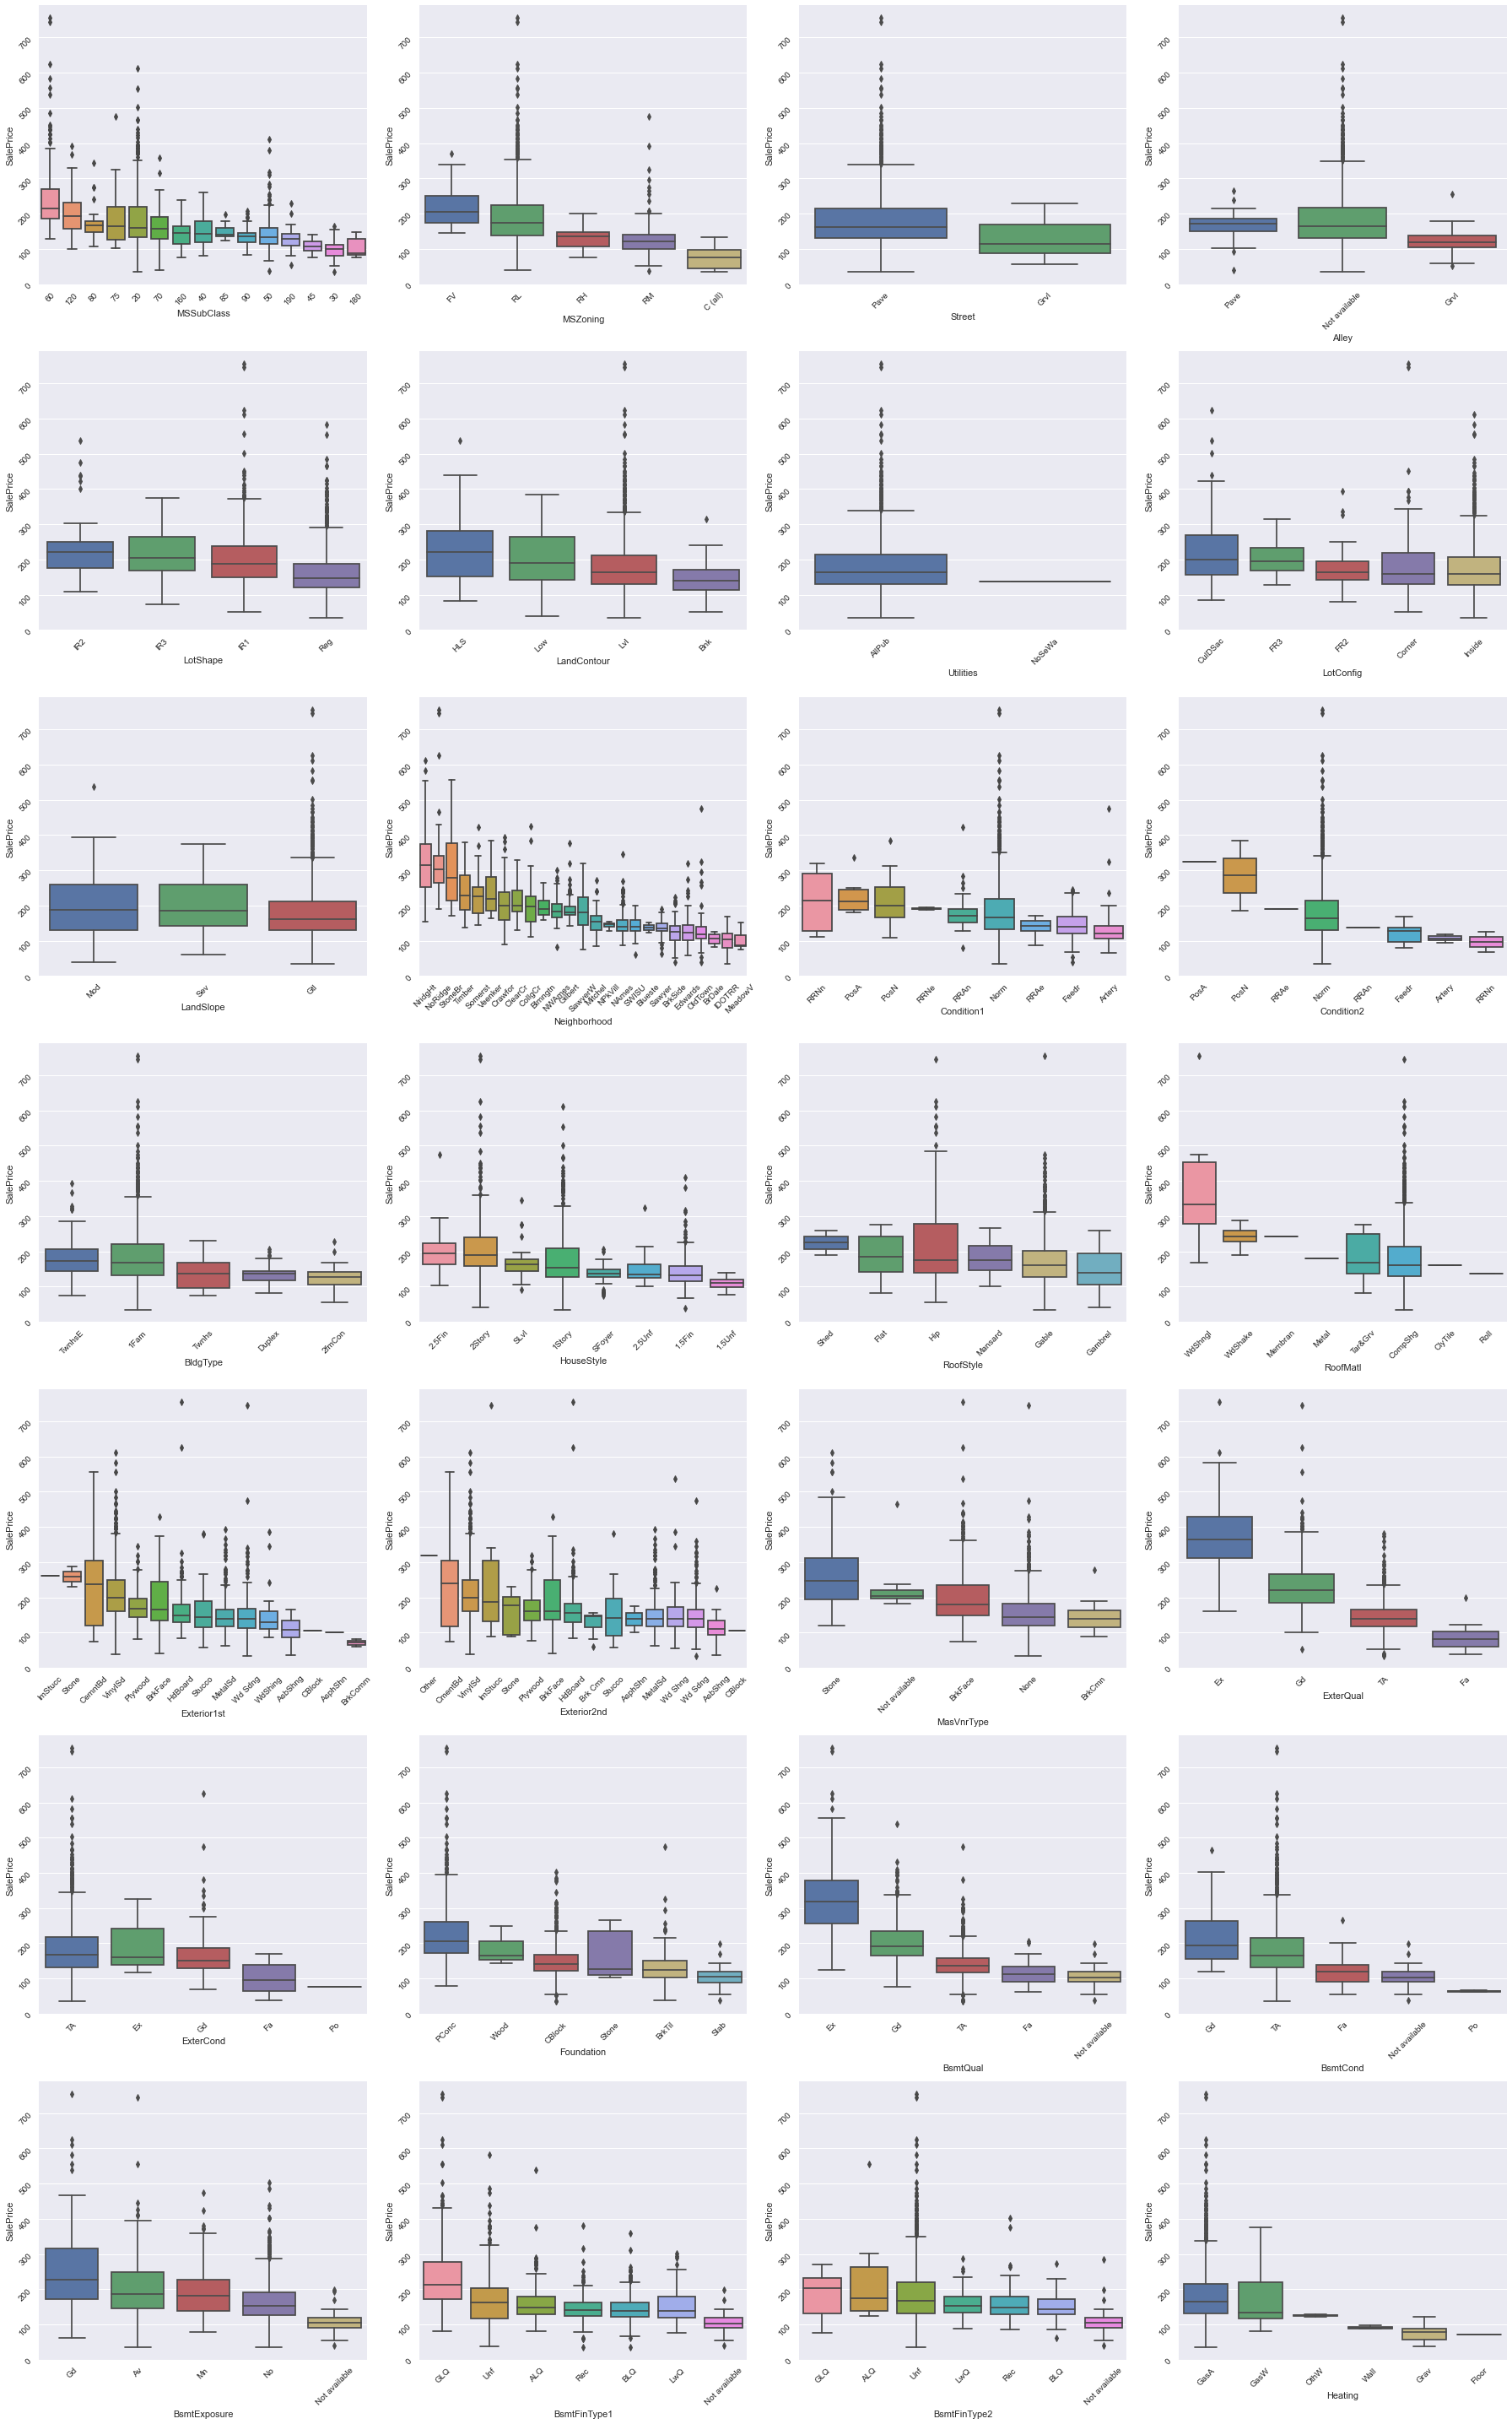

In [28]:
def box_plots_categorical(y, df):
    fig, axes = plt.subplots(7, 4, figsize=(25, 40))
    axes = axes.flatten()

    for i, j in zip(row_data[[col for col in row_data.select_dtypes(include=['object'])]], axes):
        sortd = df.groupby([i])[y].median().sort_values(ascending=False)
        sns.boxplot(x=i,
                    y=y,
                    data=df,
                    order=sortd.index,
                    ax=j)
        j.tick_params(labelrotation=45)
        plt.tight_layout()
     

box_plots_categorical('SalePrice', row_data)

In [29]:
categorical_description_df = categorical_columns.describe().T
categorical_description_df

,count,unique,top,freq
MSSubClass,1460,15,20,536
MSZoning,1460,5,RL,1151
Street,1460,2,Pave,1454
Alley,1460,3,Not available,1369
LotShape,1460,4,Reg,925
LandContour,1460,4,Lvl,1311
Utilities,1460,2,AllPub,1459
LotConfig,1460,5,Inside,1052
LandSlope,1460,3,Gtl,1382
Neighborhood,1460,25,NAmes,225


#### Подбор на категорийни променливи /feature selection/

Прави впечатление, че те често принадлежат към един или два класа от съответната категория, най-често в посока нагоре, което може да означава, че категорията не едобре разделена на класове или че променливата е излишна като цяло, тъй като в една категория попадат почти всички записи. Има нужда от задълбочен анализ, който да създаде подредени или неподредени стойности, които правилно да описват обектите на оценка.<br>
* В част от променливите, почти всички стойноти са съсредоточени само в един от класовете й. Допускаме, че същата няма особена тежест в цената на имота и затова тези променливи се премахват.
* Всички променливи, които касаят оценка на състояние и качество, са силно натоварени със субективното мнение на даващия оценката. Това може да бъде както едно лице, така и различни лица. Променливите трябва да бъдат измерими и обективни. Преценям, че тези променливи и зададените в тях стойности в голяма степен може да обърква моделите и ги отстранявам.

In [30]:
# Премахване на променливите, чиито стойности са съсредоточени в един клас
categorical_description_df[categorical_description_df.freq > 1400]

,count,unique,top,freq
Street,1460,2,Pave,1454
Utilities,1460,2,AllPub,1459
Condition2,1460,8,Norm,1445
RoofMatl,1460,8,CompShg,1434
Heating,1460,6,GasA,1428
PoolArea,1460,2,No,1453
PoolQC,1460,4,Not available,1453
MiscFeature,1460,5,Not available,1406


In [31]:
row_data = row_data.drop(categorical_description_df[categorical_description_df.freq > 1400].index, axis=1)

In [32]:
# Премахване на променливите, които са натоварени със субективна оценка
row_data = row_data.drop(['ExterQual', 'ExterCond', 'BsmtCond', 'HeatingQC', 
                    'KitchenQual', 'FireplaceQu', 'GarageQual','GarageCond',
                   'BsmtFinType1', 'BsmtFinType2'], axis=1)

#### Отстраняване на малък брой забележими аутлайъри в променливите с най-висока корелация със зависимата променлива.

In [33]:
row_data = row_data.drop(row_data[(row_data.GrLivArea > 4000) & (row_data.SalePrice < 300) ].index)
row_data = row_data.drop(row_data[(row_data.GrLivArea > 500) & (row_data.SalePrice < 50)].index)
row_data = row_data.drop(row_data[(row_data.OverallCond < 3) & (row_data.SalePrice > 300)].index)

### Подготовка и разделяне на данните на сетове за трениране и тестване

In [34]:
row_data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,...,GarageCars,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch,Fence,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Not available,Reg,Lvl,Inside,Gtl,CollgCr,...,2,Y,No,Yes,No,No,Not available,WD,Normal,208.5
1,20,RL,80.0,9600,Not available,Reg,Lvl,FR2,Gtl,Veenker,...,2,Y,Yes,No,No,No,Not available,WD,Normal,181.5
2,60,RL,68.0,11250,Not available,IR1,Lvl,Inside,Gtl,CollgCr,...,2,Y,No,Yes,No,No,Not available,WD,Normal,223.5
3,70,RL,60.0,9550,Not available,IR1,Lvl,Corner,Gtl,Crawfor,...,3,Y,No,Yes,Yes,No,Not available,WD,Abnorml,140.0
4,60,RL,84.0,14260,Not available,IR1,Lvl,FR2,Gtl,NoRidge,...,3,Y,Yes,Yes,No,No,Not available,WD,Normal,250.0


In [35]:
row_data.shape

(1454, 48)

Ще приложим следните трансформации:
* Числовите променливи с голямо опашка на изкривяване - логаритмична трансформация. Счита се, че изкривяване по-малко от 0,5 е признак за нормално разпределение. Тази трансформация ще повлияе частично и хетероскедастичната форма на данните.
* За категорийните променливи прилагаме транформиране в бинарни такива - dummies

In [36]:
skewness = row_data.select_dtypes(exclude='object').skew()
skewed_features = skewness[abs(skewness) > 0.5]
# symmetrical_features = skewness[abs(skewness) < 0.5]

row_data_log = row_data.copy()
for df in [row_data_log]:
    for col in skewed_features.index:
        df[col] = np.log1p(df[col])

In [37]:
row_data_log = pd.get_dummies(row_data_log)

In [38]:
features = row_data_log.drop('SalePrice', axis=1)
target = row_data_log['SalePrice']

In [39]:
features.shape, target.shape

((1454, 217), (1454,))

In [40]:
# Сетът е сравнително малък, затова отделяме приблизително 20% от данните за тестване.
train_features, test_features, train_target, test_target = train_test_split(
    features, 
    target, 
    test_size = 250, 
    stratify=row_data.HouseStyle, 
    random_state=30)

In [41]:
# Правим проверка на сплита
train_features.shape, train_target.shape

((1204, 217), (1204,))

In [42]:
test_features.shape, test_target.shape

((250, 217), (250,))

In [43]:
# За да може да оценим моделите преди тестване, предвид малкия брой на записите, с които разполагаме, 
# разделяме трениращите данни на 5 фолда, което е считаме, че е оптимално за нашия сет.
k_fold = KFold(n_splits=5)
k_fold_train_splits = list(k_fold.split(train_features, train_target))

### Създаване на модели и тяхното оценяване

* Linear Regression - Линейната регресия е един от най-популярни алгоритми в машинното обучение, тъй като е лесна и ясна за разбиране. В този проект ще я използваме за base line при прогнозиране на цените на жилища, за да намерим линия, която следва тренировъчния ни сет.
* Lasso е една от техникитe за намаляване на сложността на модела и предотвратяване прекалено следване на данните. Параметрите на регуляризация могат да бъдат контролирани и по този начин да се постигне по-точна оценка.
* ElasticNet e комбинация от Lasso и Ridge, като взима най-доброто и от двата модела. 
* RANSAC - модел, се базира на случайни извадки с цел да открие наличието на отклонения, които влияят върху оценката на данните. Основното допускане при него е, че данните се състоято от нормални и екстремни стойности, като вторите могат да доведат до погрешни хипотези или интерпретации.
* GBR - машинно обучение, което може да се използва за изграждане на прогнозен модел за регресионни задачи като прогнозира стойностите под формата на ансамбъл от слаби прогнозни модели. GBR повтаря многократно моделите и засилва прогнозата на моделите със слаби прогнози и ги прави по -добри. 
* SVM - LinearSVR, SVR - едни от най-силните алгоритми за всякакъв вид решения.

#### Linear Regression Grid Search 
Правим base line - Linear Regression model за да придобием представа как се справят данните определени за трениране.

In [44]:
lin_reg_model = LinearRegression()
lin_reg_model.fit(train_features, train_target)

LinearRegression()

In [45]:
lin_reg_model.score(train_features, train_target)

0.860298570803361

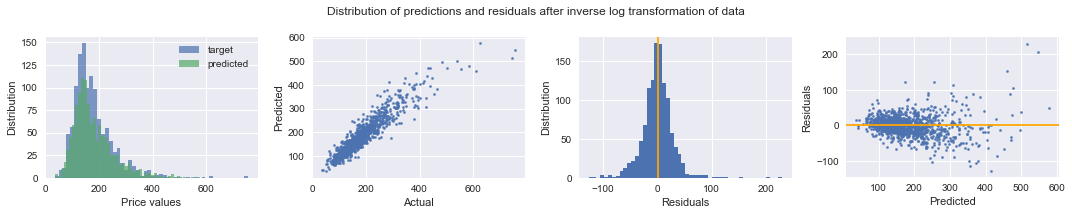

In [46]:
mutual_plot(lin_reg_model, train_features,train_target)

Резултатът е сравнително добър. Моделът се справя добре с трениращите данни, но остават хетероскедастични следи в остатъците при предвижданията.

#### Lasso Grid Search 
От базовата Linear Regression се вижда, че остатъците /residuals/ на данните следват хетероскедастичната форма както и че имат голяма вариантност. Един от подходите за отстраняване на второто е чрез регуляризация. 

In [47]:
params = {
    'alpha': [0.0001,0.0005, 0.001, 0.1],
    'max_iter': [1000, 5000, 10000],
}
grid_search_lasso = make_grid_train_model(estimator=Lasso(),
                                          params=params,
                                          cv=k_fold_train_splits,
                                          train_feat=train_features,
                                          train_tar=train_target)

GRID results:
R2 Score: 0.9259313646213665
Mean Absolute Error: 13.492642895925647
Mean Absolute Percentage Error: 0.07680414744676986
Best grid params: {'alpha': 0.0005, 'max_iter': 1000}


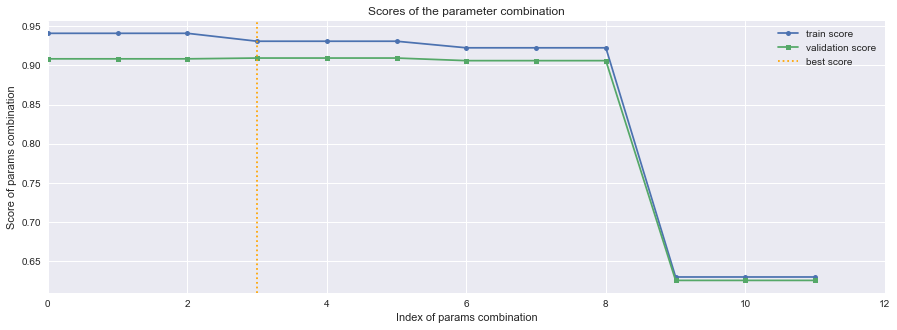

In [48]:
plot_cv_results_curves(pd.DataFrame(grid_search_lasso.cv_results_), grid_search_lasso.best_index_)

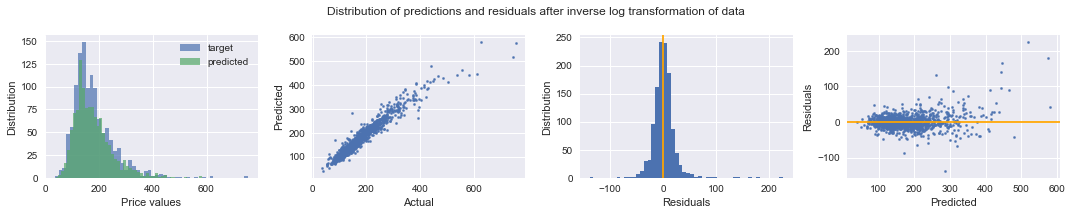

In [49]:
mutual_plot(grid_search_lasso, train_features,train_target)

In [50]:
# Проверяваме, кои променливи са с най-високи коефициенти, за да се има предвид при последващото им обследване
coef_df = pd.DataFrame(zip(test_features.columns.T, grid_search_lasso.best_estimator_.coef_ ), columns=['feature', 'coefficient'])
coef_df[abs(coef_df.coefficient) > 0].sort_values('coefficient', ascending=False).head(10)

,feature,coefficient
8,GrLivArea,0.412397
3,OverallCond,0.267288
70,Neighborhood_NoRidge,0.102449
9,BsmtFullBath,0.093437
208,SaleType_New,0.087921
1,LotArea,0.082362
61,Neighborhood_Crawfor,0.079782
71,Neighborhood_NridgHt,0.077301
77,Neighborhood_StoneBr,0.074232
174,Functional_Typ,0.073857


Очаквано, площта състоянието и локацията на имотите са с най-голямо влияние върху тяхната цена.

#### ElasticNet Grid Search
Използваме този модел за да съчетаем възможностите на Lasso и Ridge, за по-прецизна регуляризация.

In [51]:
params = {
    'alpha': [0.0001, 0.0005, 0.001, 0.01, 0.1],
    'l1_ratio': [ 0.1, 0.2, 0.3],
    'max_iter': [5000, 10000, 20000]
}
grid_search_elastic = make_grid_train_model(estimator=ElasticNet(),
                                          params=params,
                                          cv=k_fold_train_splits,
                                          train_feat=train_features,
                                          train_tar=train_target)

GRID results:
R2 Score: 0.9293394083451962
Mean Absolute Error: 13.189582558319913
Mean Absolute Percentage Error: 0.07483594921868979
Best grid params: {'alpha': 0.001, 'l1_ratio': 0.3, 'max_iter': 5000}


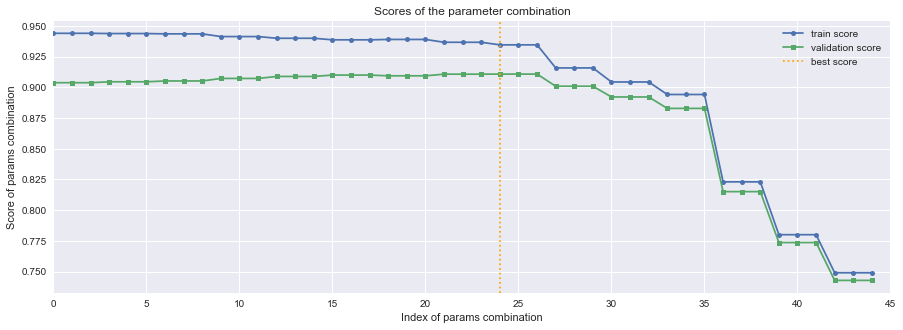

In [52]:
plot_cv_results_curves(pd.DataFrame(grid_search_elastic.cv_results_), grid_search_elastic.best_index_)

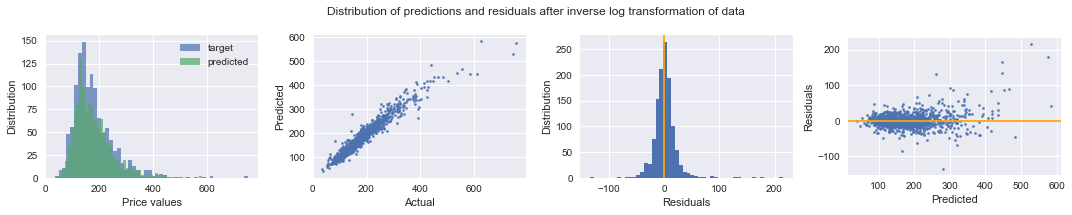

In [53]:
mutual_plot(grid_search_elastic, train_features,train_target)

И при двата модела Lasso и ElasticNet, е приложена много ниска регуляризация. Резултатите и при двата са сходни. Предвит това, може да се направи извод, че вариантността в данните се дължи не толкова на броят променливи, а по-скоро на малкият брой записи, с които разполагаме.

#### RANSAC Grid Search
RANSAC е модел, чрез който може да бъдат отделени аутлайърите в данните. Това може да бъде основа за обстойният им анализ и отстраняването им при последващи предвиждания и трениране на други модели.

In [54]:
params = {
    'min_samples': [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
}
grid_search_ransac = make_grid_train_model(estimator=RANSACRegressor(grid_search_lasso.best_estimator_),
                                          params=params,
                                          cv=k_fold_train_splits,
                                          train_feat=train_features,
                                          train_tar=train_target)

GRID results:
R2 Score: 0.9158713428991271
Mean Absolute Error: 13.66654304076041
Mean Absolute Percentage Error: 0.07763563954781252
Best grid params: {'min_samples': 0.5}


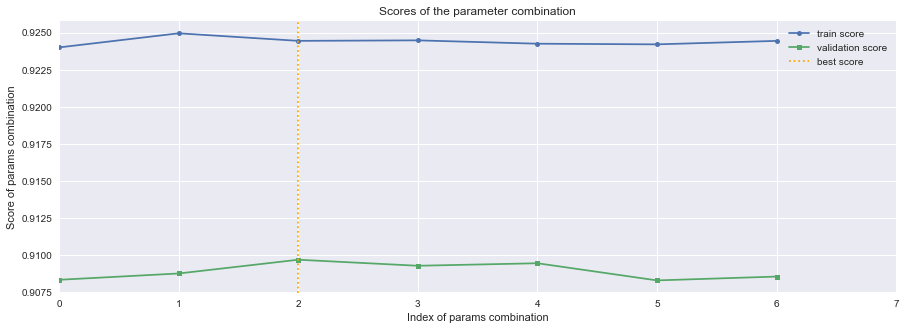

In [55]:
plot_cv_results_curves(pd.DataFrame(grid_search_ransac.cv_results_), grid_search_ransac.best_index_)

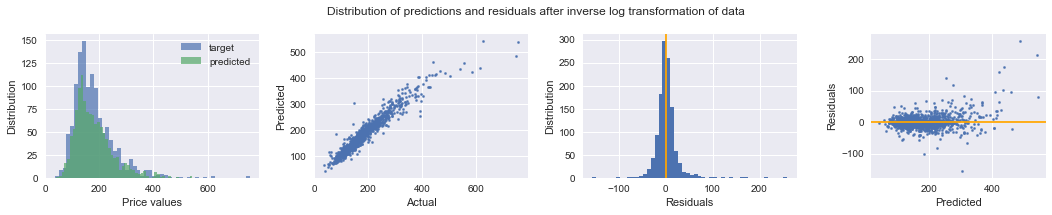

In [56]:
mutual_plot(grid_search_ransac, train_features,train_target)

In [57]:
inliers = train_features[grid_search_ransac.best_estimator_.inlier_mask_]
outliers = train_features[~grid_search_ransac.best_estimator_.inlier_mask_]
len(inliers), len(outliers)

(1167, 37)

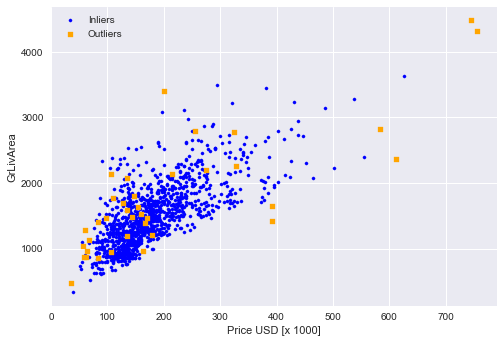

In [58]:

plt.scatter(
    np.expm1(train_target)[inliers.index], 
    np.expm1(train_features).GrLivArea[inliers.index], 
    c='blue', 
    marker='o', 
    s= 10, 
    label='Inliers'
)
plt.scatter(
    np.expm1(train_target)[outliers.index], 
    np.expm1(train_features).GrLivArea[outliers.index], 
    c='orange', 
    marker='s', 
    s=25, 
    label='Outliers'
)

plt.xlabel('Price USD [х 1000]')
plt.ylabel('GrLivArea')
plt.legend(loc='upper left')
 
plt.show()

Аутлайърите в трениращият сет са малко. Същите могат да бъдат предмет на анализ на следващ етап.

#### Grid Search GBR - Gradient Boosting Regressor
Регресионните дървета на решенията и ансамблите от тях имат склоност да овърфитват, затова пристъпваме към по-силен техен вариант. Трябва да се има предвид, че boosting алгоритмите изискват много прецизна настройка, за да могат да се представят добре освен с трениращите и тестовите данни, но и в последствие при реалната им употреба. Много малка промяна в реалните данни, с които ще се работи, могат да доведат до сериозни промени в резултатите на модела.

In [59]:
params = {
    'n_estimators': [100, 200, 300, 400, 500],
    'subsample': [0.2, 0.4, 0.6, 0.8, 0.9, 1]
}

grid_search_gbr = make_grid_train_model(estimator=GradientBoostingRegressor(),
                                          params=params,
                                          cv=k_fold_train_splits,
                                          train_feat=train_features,
                                          train_tar=train_target)

GRID results:
R2 Score: 0.9826527295635522
Mean Absolute Error: 7.632085508879786
Mean Absolute Percentage Error: 0.043140632101638626
Best grid params: {'n_estimators': 300, 'subsample': 0.6}


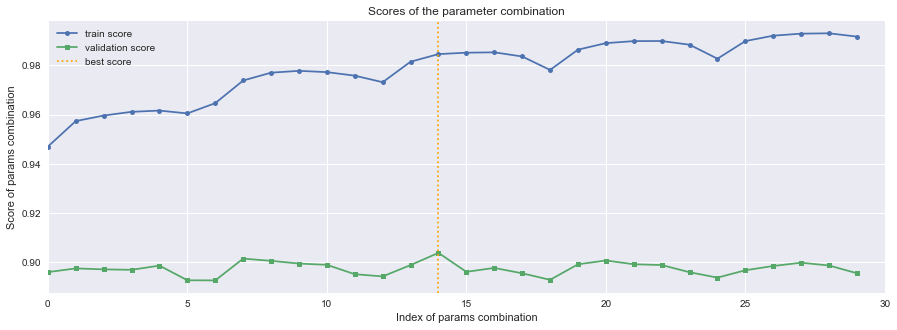

In [60]:
plot_cv_results_curves(pd.DataFrame(grid_search_gbr.cv_results_), grid_search_gbr.best_index_)

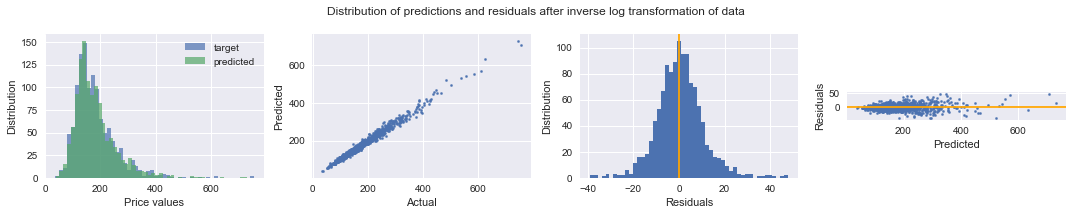

In [61]:
mutual_plot(grid_search_gbr, train_features,train_target)

In [62]:
# Проверяваме, кои са променливите с най-голямо влияние върху цената , като се има предвид, че това не е най-правилната 
# и точна мярка, но дава първична представа
feature_importance_grid_gbr = pd.DataFrame(zip(train_features.columns, grid_search_gbr.best_estimator_.feature_importances_), columns=['feature', 'importance value'])
feature_importance_grid_gbr.sort_values(by='importance value', ascending=False).head(10)

,feature,importance value
2,OverallQual,0.411201
8,GrLivArea,0.172667
7,TotalBsmtSF,0.081947
4,YearBuilt,0.040938
1,LotArea,0.035863
15,GarageCars,0.032151
5,YearRemodAdd,0.031874
3,OverallCond,0.024170
0,LotFrontage,0.016374
14,Fireplaces,0.015602


Резултатът от тази проверка потвърждава резултатите от Lasso модела. На база опитът в оценяването на недвижими имоти, тези резултати са още по-точни като към площ, локация и състояние се добавят като важност и годините на построяване и ремонт.

### Support Vector Machines

За да проверим как се представят данните с тези модели, ще направим два LinearSVR и SVR. При втория също има linear kernel, но работи по-бавно от LinearSVR.

In [63]:
params = {
    'C': [0.01, 0.1, 1],
    'max_iter':[1e6]
}

grid_search_lin_svr = make_grid_train_model(estimator=LinearSVR(),
                                          params=params,
                                          cv=k_fold_train_splits,
                                          train_feat=train_features,
                                          train_tar=train_target)

D:\anaconda\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


GRID results:
R2 Score: 0.925506092153078
Mean Absolute Error: 11.996851534236445
Mean Absolute Percentage Error: 0.0679656348717764
Best grid params: {'C': 0.1, 'max_iter': 1000000.0}


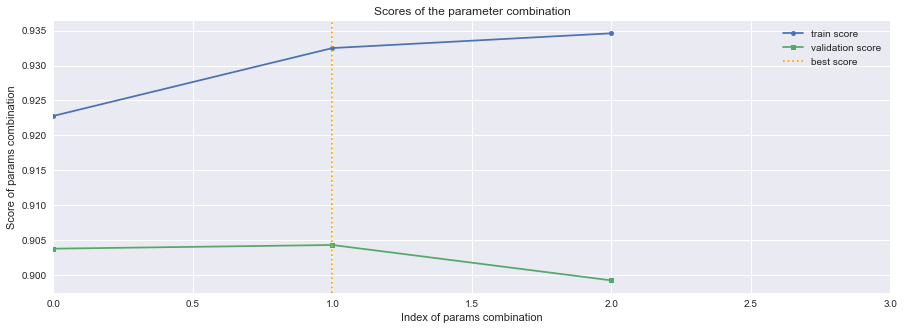

In [64]:
plot_cv_results_curves(pd.DataFrame(grid_search_lin_svr.cv_results_), grid_search_lin_svr.best_index_)

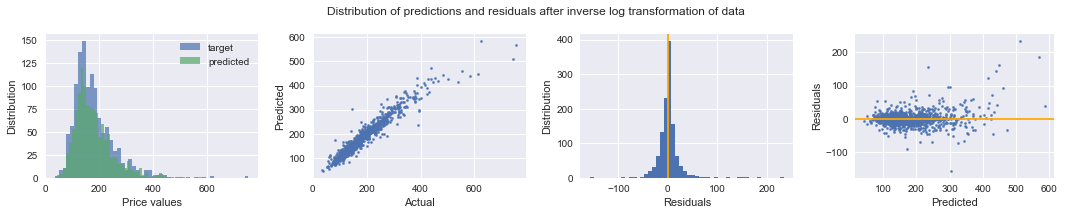

In [65]:
mutual_plot(grid_search_lin_svr, train_features,train_target)

In [66]:
params = {
    'kernel': ['rbf', 'poly'],
    'C': [0.01, 0.05, 0.1, 1, 3],
    'gamma': ['scale','auto'],
}

grid_search_svr = make_grid_train_model(estimator=SVR(),
                                          params=params,
                                          cv=k_fold_train_splits,
                                          train_feat=train_features,
                                          train_tar=train_target)

GRID results:
R2 Score: 0.9534822421461066
Mean Absolute Error: 12.094614031250769
Mean Absolute Percentage Error: 0.0693115845508088
Best grid params: {'C': 1, 'gamma': 'auto', 'kernel': 'poly'}


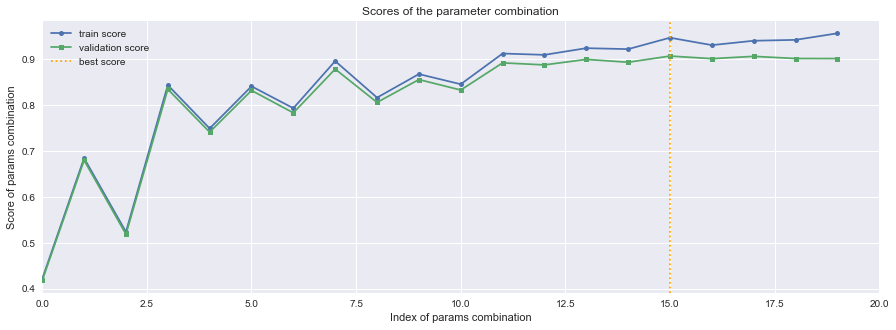

In [67]:
plot_cv_results_curves(pd.DataFrame(grid_search_svr.cv_results_), grid_search_svr.best_index_)

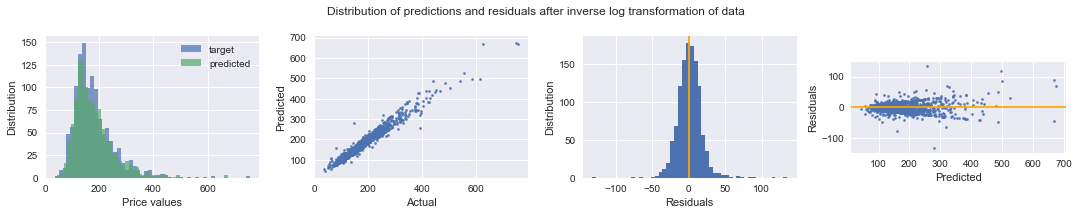

In [68]:
mutual_plot(grid_search_svr, train_features,train_target)

### 5. Резултати

In [69]:
all_models_dict = {
    'Linear Regression': lin_reg_model, 
    'Lasso': grid_search_lasso,
    'ElasticNet': grid_search_elastic,
    'RANSAC Regressor': grid_search_ransac,
    'Gradient Boosting Regressor': grid_search_gbr,
    'Linear SVR': grid_search_lin_svr,
    'SVR': grid_search_svr,
             }

In [70]:
results_df = pd.DataFrame(columns=['Model','R2 - train', 'MAE - train', 'MAPE - train'])
for name, model in all_models_dict.items():
    result = pd.DataFrame(
        data=[[name, *final_evaluation(model, train_features, train_target, test_features, test_target)]], 
        columns=['Model', 'R2 - train', 'MAE - train', 'MAPE - train']
    )
    results_df = results_df.append(result, ignore_index=True) 
    
results_df

,Model,R2 - train,MAE - train,MAPE - train
0,Linear Regression,0.868426,19.758433,0.112195
1,Lasso,0.925931,13.492643,0.076804
2,ElasticNet,0.929339,13.189583,0.074836
3,RANSAC Regressor,0.915871,13.666543,0.077636
4,Gradient Boosting Regressor,0.982653,7.632086,0.043141
5,Linear SVR,0.925506,11.996852,0.067966
6,SVR,0.953482,12.094614,0.069312


Прави впечатление, че макар и с почти еднакви R2 оценки, моделите имат разлики в абсолютната грешка и процентната грешка. SVM имат по-ниски стойности за последните две. Определяме най-добрия модел на база на MAPE тъй като целта на проекта е да се прецени доколко моделите са подходящи за иднивидуална и групова оценка на активи. Практиката е приела разликите в оценяването да бъдат изразявани и допускани като проценти.

### Избор на най-добрия модел, тестване и анализ на резултатите от него

In [71]:
# Извеждаме моделът с най-добър резултат и неговите прогнози
best_model = results_df.Model[results_df['MAPE - train'] == results_df['MAPE - train'].min()].values
best_prediction = all_models_dict[best_model[0]].predict(test_features)
best_model

array(['Gradient Boosting Regressor'], dtype=object)

In [72]:
# Тестваме модела с тестовите данни
print(f'R2 Test Score: {r2_score(test_target, best_prediction)}')
print(f'Mean Test Absolute Error: {mean_absolute_error(np.expm1(test_target), np.expm1(best_prediction))}')
print(f'Mean Test Absolute Percentage Error: {mean_absolute_percentage_error(np.expm1(test_target), np.expm1(best_prediction))}')

R2 Test Score: 0.9354472043524288
Mean Test Absolute Error: 13.478953467645427
Mean Test Absolute Percentage Error: 0.07448563733597616


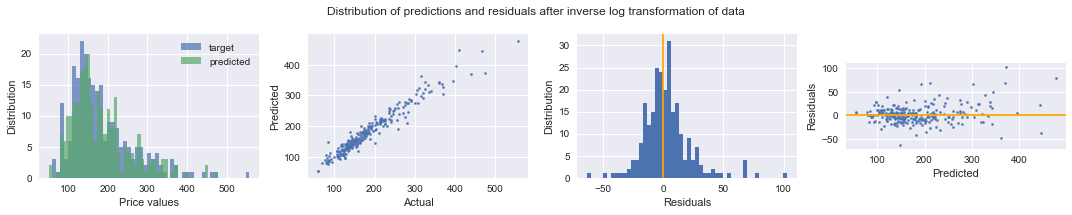

In [73]:
# Плотвеме резултатите като правим обратна логаритмична трансформация, за да видим реалните стойности.
mutual_plot(all_models_dict[best_model[0]], test_features, test_target)

In [74]:
test_prices = np.expm1(test_target)
predicted_prices = np.expm1(best_prediction)
residuals = test_prices - predicted_prices
predicted_prices_df = pd.DataFrame({'test_set_index': test_target.index,
                                    'test_price': list(test_prices), 
                                    'predicted_price': list(predicted_prices), 
                                    'residuals': list((residuals)), 
                                    'residuals_%': list(((residuals)/test_prices)*100),
                                    })
predicted_prices_df.sample(10)

,test_set_index,test_price,predicted_price,residuals,residuals_%
151,1453,84.5,147.778995,-63.278995,-74.886385
186,911,143.5,158.186305,-14.686305,-10.234359
91,857,174.0,168.959265,5.040735,2.896974
111,160,162.5,163.443208,-0.943208,-0.580435
180,1173,200.5,232.286801,-31.786801,-15.853766
54,332,284.0,274.570319,9.429681,3.320310
246,429,175.0,179.141926,-4.141926,-2.366815
30,13,279.5,211.116255,68.383745,24.466456
163,86,174.0,173.729239,0.270761,0.155610
73,82,245.0,249.138861,-4.138861,-1.689331


In [75]:
# Извеждаме предвижданията, чиито процент остатъци са по-малко или равни на 5%
len(predicted_prices_df[abs(predicted_prices_df['residuals_%']) <= 5])/len(predicted_prices_df)

0.48

In [76]:
# Извеждаме предвижданията, чиито процент остатъци са по-малко или равни на 7%
len(predicted_prices_df[abs(predicted_prices_df['residuals_%']) <= 7])/len(predicted_prices_df)

0.592

In [77]:
test_prices.sum(), predicted_prices.sum(), test_prices.sum()-predicted_prices.sum()

(46348.969000000005, 45645.005816988596, 703.9631830114085)

### Заключения


Може да се отбележи, че всички модели имат много близки резултати. Разликата в оценката при трениращите и валидиращите данни не е голяма при всеки един от тях, но са достатъчно високи, което ни кара да смятаме, че няма наклонност /bias/. За сметка на това може да се каже, че има някаква вариантност. Още при подготовката на данните за прилагане, са извършени действия, които са с цел намаляването на същата.<br>
В предвижданията остават следи и от хетероскедастичната форма на данните. Трябва да се отбележи, че хетероскедастичността е разбираемо явление в данните за реализация на недвижимите имоти. Практиката показва, че дори и при оценка на независими експерти оценители, разликити в по-скъпите имоти, могат да бъдат значителни и този ефект се усилва с покачването на цената. В категорията на луксозните имоти има и голямо влияние на субективни фактори и решения.<br>
Въпреки това, смятам че моделите и резултатите им могат да бъдат подобрени чрез:
* преразглеждане и предефиниране на таргет променливата за да се опитаме да избегнем хетероскедастичността - например, може да бъде преработена в цена на кв.м. което също би намалило разликата в ниските и високите стойности 
* добавянето на още записи към данните /при липса на такива bootstraping/ 
* обстоен анализ на аутлайърите, за да се види дали не би могло данните да бъдат разделяни на база някоя от променливите, като за всяка отделна група да се изготвят и тренират различни модели.
* промяна в моделиращата функция, чрез добавяне на допълнителен параметър, който е функция на независимата променлива




Предвид получените резултати, може да се приеме, че в този вариант, най-добрият модел би могъл да бъде използван за консултиране на приблизителна стойност на пакет от активи при условие на +- 7% грешка.<br>
За оценка на индивидуални стойности, бихме могли да приемем модел, при който всяка една предвидена стойност е с грешка мужду +-5%, каквато моделите ни не постигат.

### Референции

1. Machine Learning - септември 2021  - SoftUni, лектор - Йордан Даракчиев
2. https://scikit-learn.org/stable/
3. House Prices: Advanced Regression Techniques https://www.kaggle.com/c/house-prices-advanced-regression-techniques/code
4. Housing Sale Price Prediction Using Machine Learning Algorithms https://escholarship.org/uc/item/3ft2m7z5
5. Hands-on Machine Learning with Scikit-Learn, Keras, and TensorFlow, the cover image, and related trade dress are trademarks of O’Reilly Media, Inc.
6. Европейски Стандарти за оценяване http://private.ciab-bg.com/uploads/common/ag865nhr4kmxc209.pdf 